# MNIST ROC Curve

A neural network that recognized MNIST handwritten digits. In this exerciso we are going to cover a model
evaluation using confusion matrix and Receiver Operating Characteristic (ROC).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from nn_mnist_model import MNISTModel
import tensorflow as tf

plt.style.use('ggplot')
mpl.style.use("seaborn")
plt.rcParams['figure.figsize'] = (20,10)

In [2]:
# Crete the Model
mnist_model = MNISTModel(
    epochs=200,
    batch_size=128
)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-03-14 01:30:26.307237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-14 01:30:26.307396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load and get the train and test data

In [3]:
mnist_model.load_data()

## Build the model

In previos trainig configuration for the newural Network, we found a configuration with a 2 hiddden layer of 128 and 64 units with relu actiovation
give us the 99 % in accuracy and 97 % in validation. For this example, we are using thta network configuration to train and build the ROC curves.

In [4]:
# Build the model.
mnist_model.build([
    [128,'relu'], # Hidden layer 1
    [64,'relu']   # Hidden layer 2
])
# Summary of the model
mnist_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer-1 (Dense)       (None, 128)               100480    
                                                                 
 dense_layer-2 (Dense)       (None, 64)                8256      
                                                                 
 dense_layer-3 (Dense)       (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Cpmpile the Model

By default, the optimizer is **SGD**, loss `categorical_crossentropy` and metrics `[accuracy]`.

In [5]:
# Compiling the model.
mnist_model.compile()

## Train the Neural Network

In [ ]:
mnist_model.fit()

## Plot Learning curve

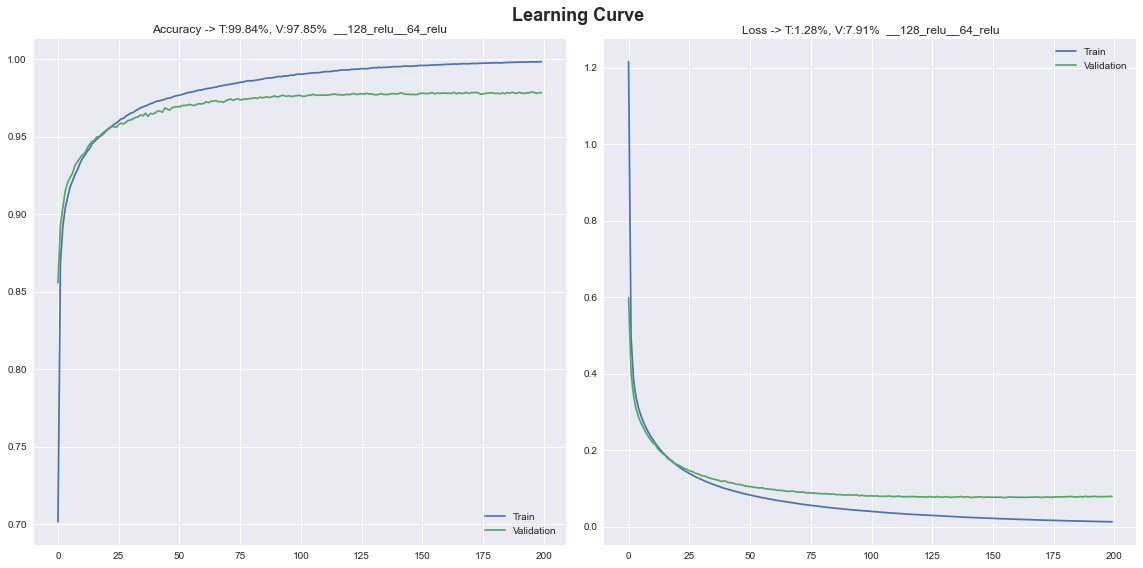

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))
ax_acc, ax_loss = axs.flat[:2]
fig.suptitle("Learning Curve", fontsize=18, fontweight='bold')
fig.tight_layout()
history = mnist_model.history.history
epochs_line = range(mnist_model.history.params["epochs"])

# Accuracy plot
acc = history["accuracy"]
val_acc = history['val_accuracy']
plot_tile = "Accuracy -> T:{:.2f}%, V:{:.2f}% ".format(acc[-1]*100, val_acc[-1]*100)
if len(mnist_model.model.layers) > 1:
    plot_tile = "{} {}".format(plot_tile, mnist_model.descriptive_name)
ax_acc.set_title(plot_tile)
ax_acc.plot(epochs_line, acc, label="Train")
ax_acc.plot(epochs_line, val_acc, label="Validation")
ax_acc.legend(loc="lower right")

# Loss Plot
loss = history["loss"]
val_loss = history['val_loss']
plot_tile = "Loss -> T:{:.2f}%, V:{:.2f}% ".format(loss[-1]*100, val_loss[-1]*100)
if len(mnist_model.model.layers) > 1:
    plot_tile = "{} {}".format(plot_tile, mnist_model.descriptive_name)
ax_loss.set_title(plot_tile)
ax_loss.plot(epochs_line, loss, label="Train")
ax_loss.plot(epochs_line, val_loss, label="Validation")
ax_loss.legend(loc="upper right")

In [8]:
loss, acc = mnist_model.model.evaluate(mnist_model.X_test, mnist_model.Y_test)
print("Model Accuray:{:.2f}% , loss:{}".format(acc * 100, loss))

313/313 [==============================] - 2s 8ms/step - loss: 0.0791 - accuracy: 0.9785
Model Accuray:97.85% , loss:0.07912319898605347


# Evaluate the Performance of the model

For this neural network, we are going to evaluate the peformance covering the following methods:
- Confussion Matrix
- ROC Curve



### Confusion Matrix

We are going to use the test dataset to predict the values and then use them to compute the confusion matrix and other evaluation metrics.

In [9]:
y_pred = mnist_model.model.predict(mnist_model.X_test)

2022-03-14 01:44:36.536265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(
[[ 966    0    0    0    1    2    4    2    4    1]
 [   0 1125    4    0    0    1    2    1    2    0]
 [   3    2 1008    7    2    0    1    4    4    1]
 [   0    0    3  991    0    4    0    3    3    6]
 [   1    0    2    1  968    0    4    0    1    5]
 [   2    1    0   13    1  866    4    1    3    1]
 [   4    3    0    1    3    4  942    1    0    0]
 [   1    4    9    3    3    0    0 1000    3    5]
 [   3    1    3   10    3    2    4    4  941    3]
 [   3    2    0    6   10    0    1    8    1  978]], shape=(10, 10), dtype=int32)


<AxesSubplot:>

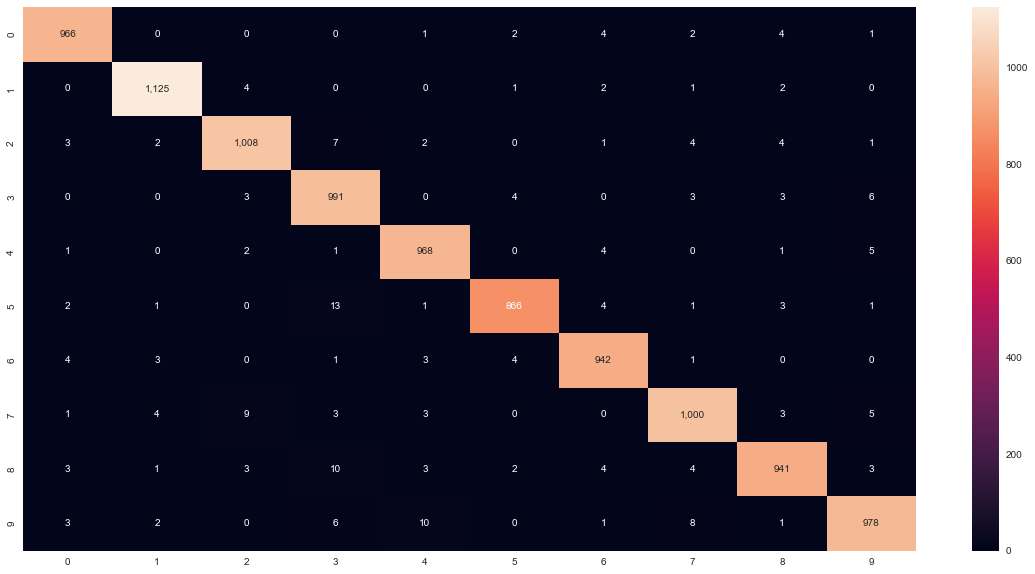

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
labels = mnist_model.Y_test.argmax(axis=1)
predictions = y_pred.argmax(axis=1)
num_classes = 10
cm =tf.math.confusion_matrix(labels=labels, predictions=predictions, num_classes=num_classes)
print(cm)
sns.heatmap(cm.numpy(), annot=True, fmt=',') # Thoussands comma separated

Plot of Confusion matrix usinf percentage

<AxesSubplot:>

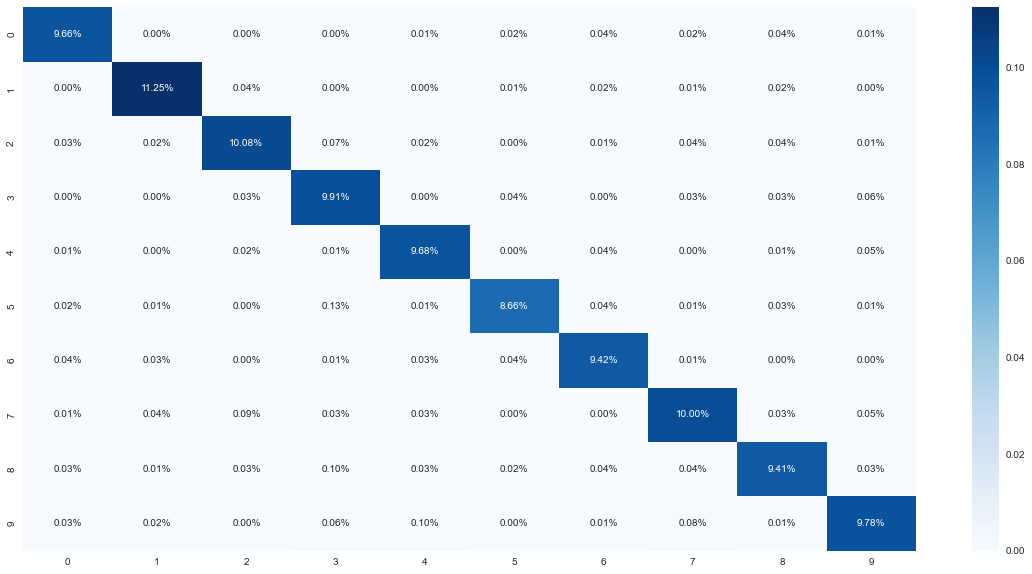

In [11]:
cm_sum = np.sum(cm.numpy())
sns.heatmap(cm.numpy()/cm_sum, annot=True, fmt='.2%', cmap='Blues')

### ROC and AUC

In this section we are going to create a Receiver Operating Characteristic (ROC) curve plots. This metric 
will help us to evaluate the output quality of the Neural Network model. 

The AUC (Area under Curve) is useful to get metric of the performance of the model, usually a larger area under the curve is better.

The ROC graph has the TPR (True Positive Rate) in the `x` axis and FPR(False Positive Rate) in the `y` axis. The formulas are the Following:


#### Confusion matrix elements in a binary clasification

||Positive|Negative|
|---|---|---|
|Positive|TP = True Positive| FN = False Negative|
|Negative|FP = False Positive| TN = True Negative| 


True Positive Rate fomula
$$
TPR = TP / (TP + FN)
$$

False Porsitive rate formula
$$
FPR = FP / (FP + TN) 
$$


To construct our ROC graph we have to choose a thershold to create the distict partiotions to then
 calculate  the `TPR` and `FPR` on each thershold iteration.

 In the nex fuction, the TPR, FPR and Thresholds are computed from y_true and y_score.


In [13]:

def roc_curve_custom(y_true, y_score):
    """Calculates the TRP and FPR
    :return (tpr, fpr, thresholds): True Posistive Rate and False Positive Rate
    """
    # sort the scores and save the sorted indexes
    score_indexes_sorted = np.argsort(y_score, kind="mergesort")
    # y_true and y_score are now sorted
    y_true = y_true[score_indexes_sorted]
    y_score = y_score[score_indexes_sorted]

    # get only the distict values from the diff
    # appliying the np.where to get the indexes to then 
    # create the threshold indexes
    threshold_indexes = np.where(np.diff(y_score))[0]
    # concatenate the value of the end of the curve
    threshold_indexes =  np.r_[threshold_indexes, len(y_true)-1]

    # compute the cumulative sum and select form the threshold
    tps = np.cumsum(y_true)[threshold_indexes]        # True Positive sum
    fps = np.cumsum(1 - y_true)[threshold_indexes]    # False Posotive sum
    thresholds = y_score[threshold_indexes]           # The Thresholds

    # Add an extra threshold position to start the curve at (0,0)
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    thresholds = np.r_[thresholds[0] + 1, thresholds]

    # Calculate the True Positive Rate
    tpr =  tps / tps[-1] 
    # Calculate the False Positive Rate
    fpr = fps / fps[-1]
    return tpr, fpr, thresholds

#### Computing the FRP and TPR for each class

We are going to use our algorithm and the the one from scikit learn to compute the ROC curve. We have to calculate the ROC for each of the classes.

In [26]:
from sklearn.metrics import roc_curve, auc

tpr = {}
fpr= {}
roc_auc = {}
tpr_custom = {}
fpr_custom = {}
roc_auc_custom = {}
for i in range(mnist_model.nb_classes):
    # Compute from scikit learn
    fpr[i], tpr[i], _ = roc_curve(mnist_model.Y_test[:,i], y_pred[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute from our function
    fpr_custom[i], tpr_custom[i], _ = roc_curve_custom(mnist_model.Y_test[:,i], y_pred[:,i])
    roc_auc_custom[i] = auc(fpr_custom[i], tpr_custom[i])

#### Plot all ROC cueves for each class

We are going to create a function to plot all ROC curves from `fpr`, `tpr` and `auc`.

In [27]:
from itertools import cycle

def plot_all_roc(fpr, tpr, roc_auc):
    lw = 2
    n = mnist_model.nb_classes
    cols = 3
    plot_rows = int(n/cols) + n % cols
    last_blank_cols = (plot_rows * cols) - n
    fig, axs = plt.subplots(plot_rows, cols, figsize=(20, 20))
    fig.suptitle("Receiver Operating Characteristic for MNIS NN Model", fontsize=18, fontweight='bold')
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "brown", "tomato","greenyellow", "gold","fuchsia","peru","royalblue"])
    for i, ax, color in zip(range(n), axs.flat, colors):
        ax.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )
        ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_title("Receiver operating characteristic class;{}".format(i))
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")
    for i in range(last_blank_cols):
        axs.flat[-(i+1)].axis('off') # clear existing plot
    plt.show()


This first plots are from the computed scikit learn functions

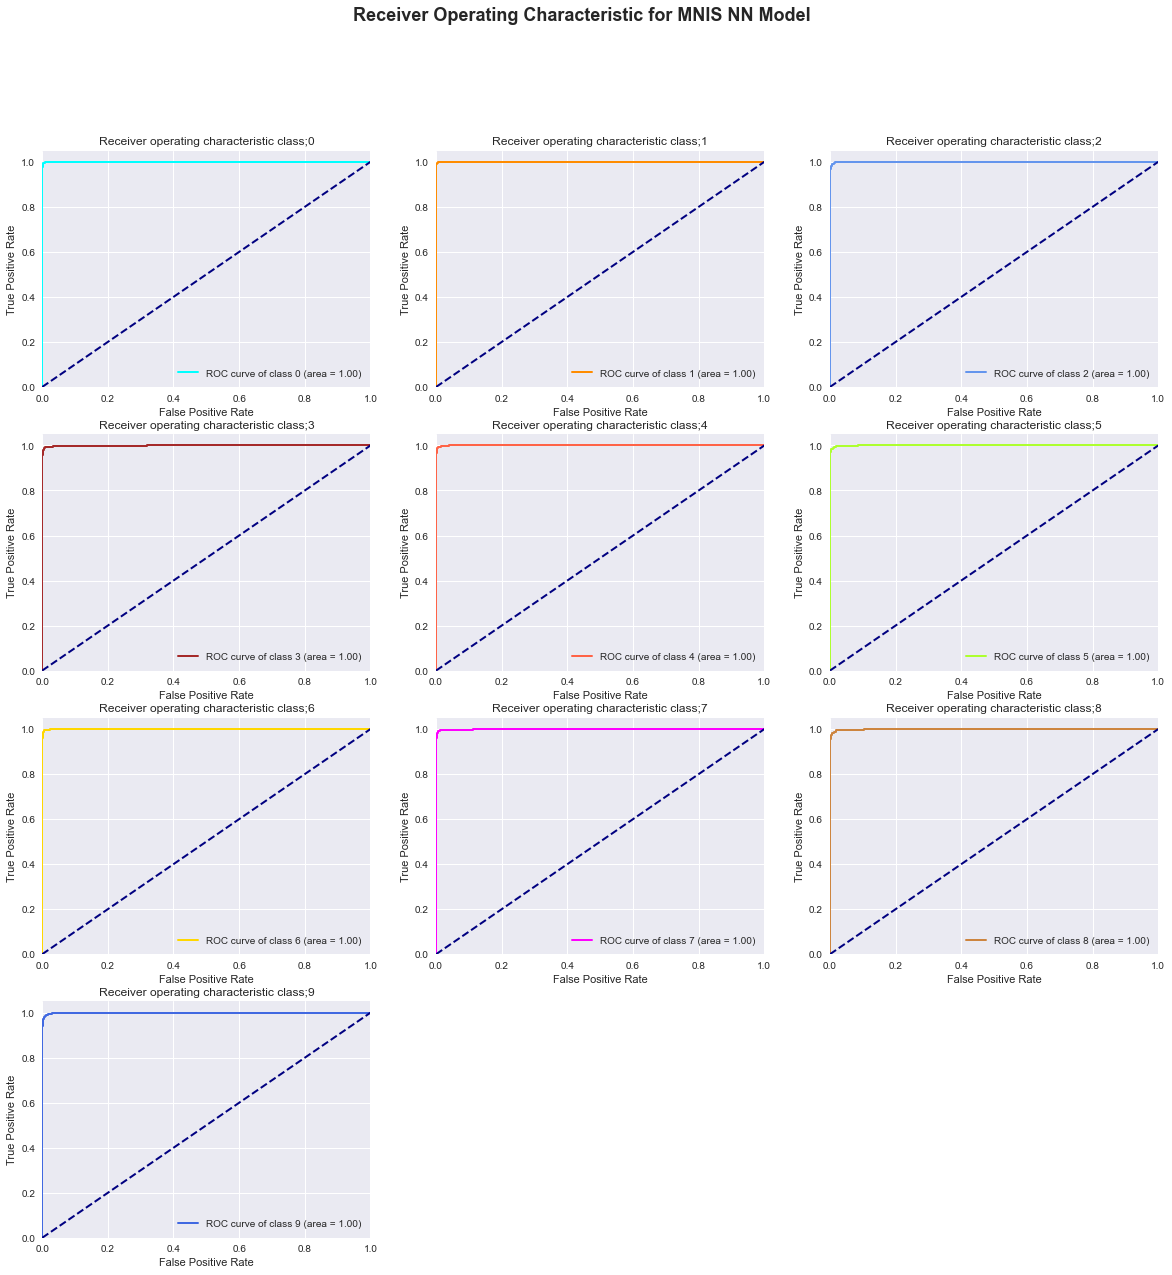

In [25]:
plot_all_roc(fpr, tpr, roc_auc)

The nex plot, are the ROC curves generated for our implemented code in the function `roc_curve_custom`.

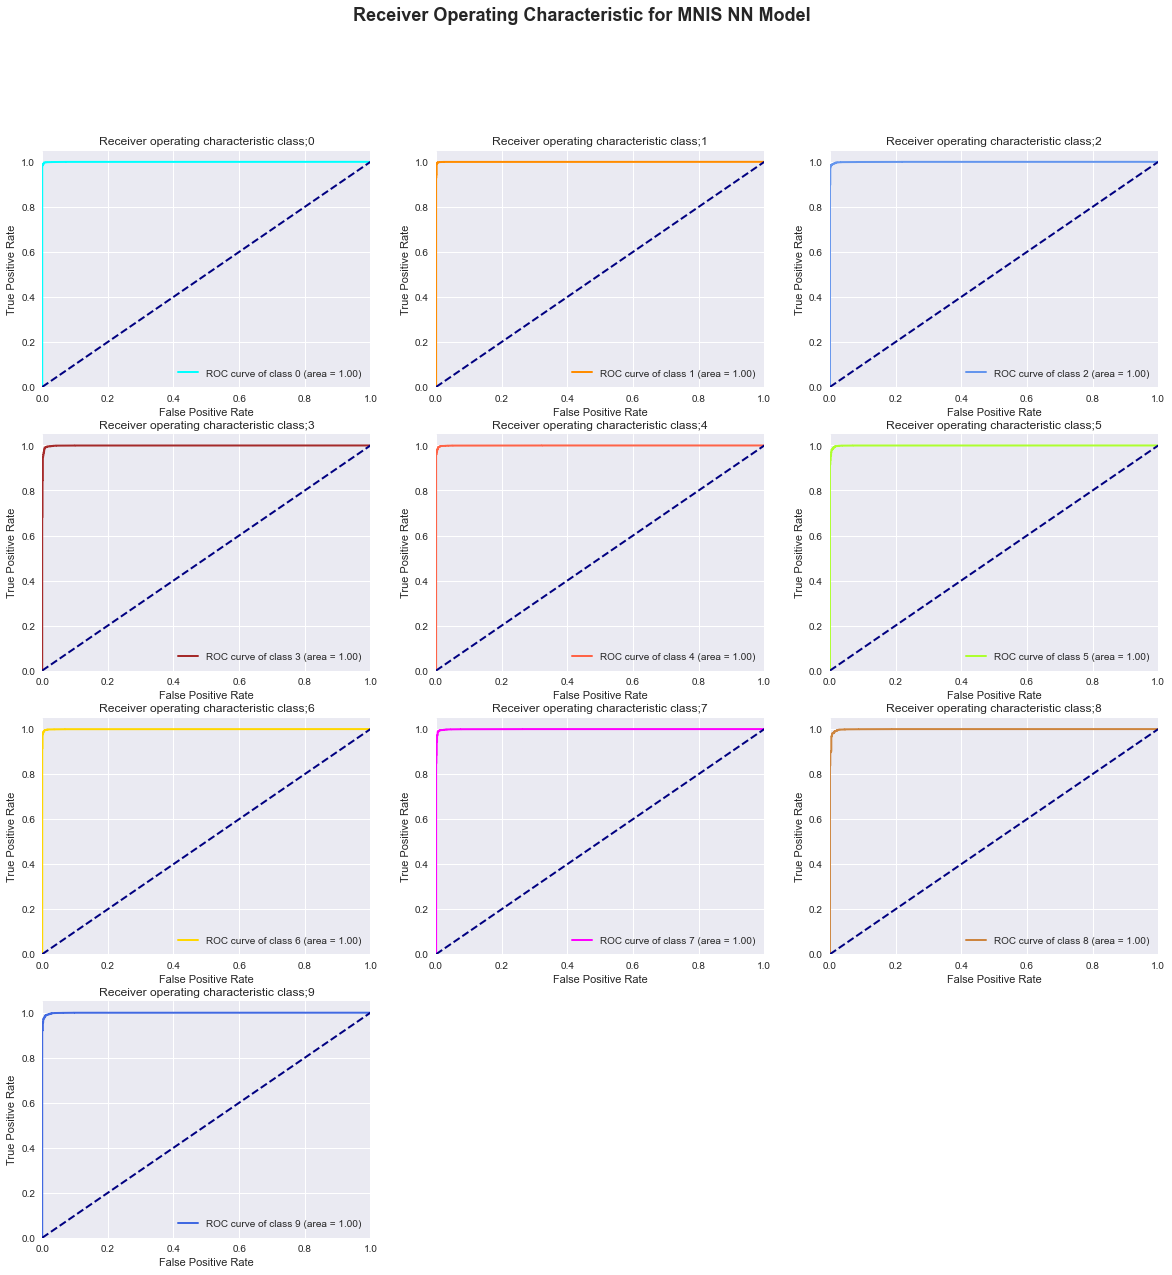

In [28]:
plot_all_roc(fpr_custom, tpr_custom, roc_auc_custom)

#### Compute micro and macro avergae ROC curves and ROC areas

In [30]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mnist_model.Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute the macro-avergae ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(mnist_model.nb_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(mnist_model.nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= mnist_model.nb_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

Plot all toguether

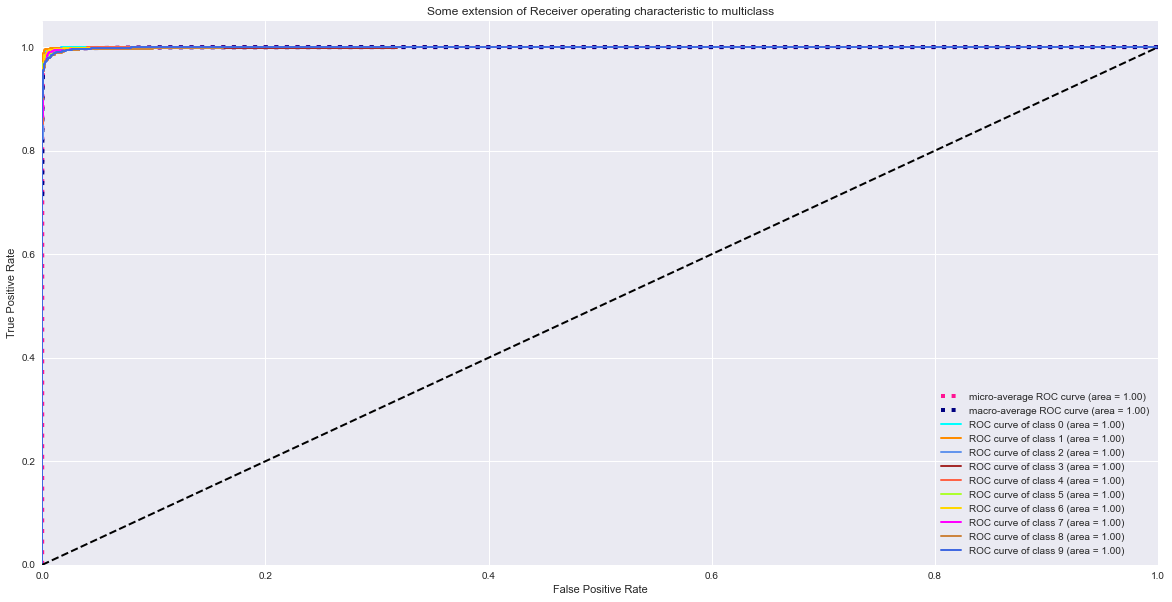

In [37]:
plot_x = [fpr["micro"] , fpr["macro"] ] + [fpr[i] for i in range(mnist_model.nb_classes)]
plot_y = [tpr["micro"] , tpr["macro"] ] + [tpr[i] for i in range(mnist_model.nb_classes)]
labels = ["{0}-average ROC curve (area = {1:0.2f})".format(k, roc_auc[k]) for k in ["micro", "macro"]]
labels = labels + ["ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]) for i in range(mnist_model.nb_classes)]
colors = cycle(["deeppink", "navy", "aqua", "darkorange", "cornflowerblue", "brown", "tomato", "greenyellow", "gold", "fuchsia", "peru", "royalblue"])
plt.figure()
for i, x, y, label, color in zip(range(mnist_model.nb_classes + 2), plot_x, plot_y,labels, colors):
    kargs = {"color":color, "lw":2, "label": label}
    if i < 2:
        kargs["lw"] = 4
        kargs["linestyle"] = ":"
    plt.plot(x,y, **kargs)
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()